In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import progressbar
from scipy import stats
sns.set()

%matplotlib inline

# Define path and load files 

Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [2]:
data = "../Data"
resultpath = '../Results'
PPI_ID = "2018_08"

In [3]:
G = nx.read_graphml(os.path.join(data, 'PPIs', 'PPI_{}.graphml'.format(PPI_ID)))

hipo_ova = pd.read_csv(os.path.join(data,'Screen/hipo_ova_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen/xRNAi_fec_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data,'Screen/hipo_fec_clean.csv'))

hipo_ova_pred = pd.read_csv(os.path.join(data,'Screen/hipo_ova_clean_pred.csv'))
xRNAi_fec_pred = pd.read_csv(os.path.join(data,'Screen/xRNAi_fec_clean_pred.csv'))
hipo_fec_pred = pd.read_csv(os.path.join(data,'Screen/hipo_fec_clean_pred.csv'))

signaling = pd.read_csv(os.path.join(data,'signaling.csv'))
connectors= pd.read_csv(os.path.join(resultpath,"ConnectorGeneList_{}.csv".format(PPI_ID)))

In [4]:
# We only consider the sum of eggs layed over 5 days, so we restrict the data to the "Sum"
xRNAi_fec = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].reset_index(drop=True)
hipo_fec = hipo_fec[hipo_fec['Condition'] == 'Sum'].reset_index(drop=True)

xRNAi_fec_pred = xRNAi_fec_pred[xRNAi_fec_pred['Condition'] == 'Sum'].reset_index(drop=True)
hipo_fec_pred = hipo_fec_pred[hipo_fec_pred['Condition'] == 'Sum'].reset_index(drop=True)

In [5]:
# Modules computed in the notebook file: Seed-Connector
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module_{}.graphml'.format(PPI_ID)))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module_{}.graphml'.format(PPI_ID)))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module_{}.graphml'.format(PPI_ID)))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module_{}.graphml'.format(PPI_ID)))

In [6]:
signaling_meta = pd.read_csv(os.path.join(data, "signaling.csv"))

# Prepare groups of genes and positive candidate set
Here we calculate the mean of the Zscore for each gene in the screens, define thresholds for significance, and create subsets of genes

In [7]:
mean_ova_gene = hipo_ova.append(hipo_ova_pred).groupby('FbID', as_index=False).mean()
mean_fec_gene = hipo_fec.append(hipo_fec_pred).groupby('FbID', as_index=False).mean()
mean_xRNAi_gene = xRNAi_fec.append(xRNAi_fec_pred).groupby('FbID', as_index=False).mean()

In [8]:
assert(len(set(mean_ova_gene['FbID'].unique()).difference(set(mean_fec_gene['FbID'].unique()))) == 0)

In [9]:
assert(len(set(mean_xRNAi_gene['FbID'].unique()).difference(set(mean_fec_gene['FbID'].unique()))) == 0)

In [10]:
assert(len(mean_ova_gene) == 273 + 32 +1)
assert(len(mean_xRNAi_gene) == 273 + 32 +1)
assert(len(mean_fec_gene) == 465 + 23 + 1)

In [11]:
ova_module = ova_module_G.nodes()
fec_module = fec_module_G.nodes()
xRNAi_module = xRNAi_module_G.nodes()
core_module = core_module_G.nodes()

In [12]:
# Here we select all the genes that were tested in the screen,
# because the first screen was Hipo RNAi EggLaying measurement, this dataset contains all the tested genes
screen_genes = mean_fec_gene['FbID'].values
ScreenG = G.subgraph(screen_genes)

In [13]:
# We redefine our threshold of 2 and 5 for Z score cutoff
ova_threshold = 2
eggl_threshold = 5

In [14]:
allgenes = np.unique(list(set.union(set(ova_module), set(xRNAi_module), set(fec_module), set(core_module))))
all3 = set.intersection(set(ova_module), set(xRNAi_module), set(fec_module))
ovafec = set.intersection(set(ova_module), set(fec_module))
ovaxRNAi = set.intersection(set(ova_module), set(xRNAi_module))
xRNAifec = set.intersection(set(fec_module), set(xRNAi_module))
core = set(core_module)

# Building the meta module network

In [15]:
# Create the network composed of all 4 modules aggregated
subG = nx.compose(ova_module_G, fec_module_G)
subG = nx.compose(subG, xRNAi_module_G)
subG = nx.compose(subG, core_module_G)

In [16]:
# Extract the locations in modules for all genes in the MetaNetwork
for node in subG.nodes():
    # Define the location in modules
    # Ova / HipoEggL / Eggl 
    key = ['0','0','0']
    if node in ova_module:
        key[0] = '1'
    if node in fec_module:
        key[1] = '1'
    if node in xRNAi_module:
        key[2] = '1'
    if node in core_module:
        key[0] = '1'
        key[1] = '1'
        key[2] = '1'
    subG.nodes[node]['overlap'] = ''.join(key)

In [17]:
# Extract the Z_scores for all the nodes
scores_ova = {}
scores_fec = {}
scores_xRNAi = {}
scores = {}
for node in subG.nodes():
    Z = []
    if node in mean_xRNAi_gene['FbID'].unique():
        z = mean_xRNAi_gene[mean_xRNAi_gene['FbID'] == node]['Z'].values[0]
        Z.append(z)
        scores_xRNAi[node] = z
    if node in mean_fec_gene['FbID'].unique():
        z = mean_fec_gene[mean_fec_gene['FbID'] == node]['Z'].values[0]
        Z.append(z)
        scores_fec[node] = z
    if node in mean_ova_gene['FbID'].unique():
        z = mean_ova_gene[mean_ova_gene['FbID'] == node]['Z'].values[0]
        Z.append(z)
        scores_ova[node] = z
    if len(Z) == 3:
        scores[node] = np.mean(Z)

In [18]:
# Decorate the network by adding all the calculated fileds above
for node in subG.nodes():
    if node in scores:
        Z = scores[node]
        if node in scores_ova:
            Z_ova = scores_ova[node]
        else:
            Z_ova = 0.0
        if node in scores_fec:
            Z_fec = scores_fec[node]
        else:
            Z_fec = 0.0
        if node in scores_xRNAi:
            Z_xRNAi = scores_xRNAi[node]
        else:
            Z_xRNAi = 0.0
        subG.nodes[node]['Z'] = abs(float(Z))
        subG.nodes[node]['Z_ova'] = abs(float(Z_ova))
        subG.nodes[node]['Z_fec'] = abs(float(Z_fec))
        subG.nodes[node]['Z_xRNAi'] = abs(float(Z_xRNAi))
    else:
        subG.nodes[node]['Z'] = 0.0
        if node in scores_ova:
            subG.nodes[node]['Z_ova'] = abs(float(scores_ova[node]))
        else:
            subG.nodes[node]['Z_ova'] = 0.0
        
        subG.nodes[node]['Z_fec'] = 0.0
        subG.nodes[node]['Z_xRNAi'] = 0.0
    sigs = signaling[signaling['FbID'] == node]['Sig'].values
    for sig in signaling['Sig'].unique():
        if sig in sigs:
            subG.nodes[node][sig] = 1
        else:
            subG.nodes[node][sig] = 0

In [19]:
# Adding the labels on nodes if they are receptor or ligand

for node in subG.nodes():
    if node in signaling_meta['FbID'].values:
        types = signaling_meta[signaling_meta['FbID']== node]['KeyMember'].values[0]
        if type(types) == str:
            if types == "Ligand":
                subG.nodes[node]["SigType"] = "Ligand"
            else:
                subG.nodes[node]["SigType"] = "Receptor"
        else:
            subG.nodes[node]["SigType"] = "Else"            
    else:
        subG.nodes[node]["SigType"] = "Else"

In [37]:
nx.write_graphml(subG, os.path.join(resultpath, 'Meta_module_{}.graphml'.format(PPI_ID)))

# Making a table of the metanetwork

In [20]:
res = []
sigs = signaling['Sig'].unique()
for node in subG.nodes():
    n = subG.nodes[node]
    S = []
    for sig in sigs:
        S.append(subG.nodes[node][sig])
    res.append([node, n['label'], n['Seed'], n['Z_ova'], n['Z_fec'], n['Z_xRNAi'], str(n['overlap'])] + S)
metatable = pd.DataFrame(res, columns=['FbID', 'GeneName', 'Type', 'Z_ovariole', 'Z_HpoEggL', 'Z_EggL', 'Overlap'] + list(sigs))

In [39]:
metatable.to_csv(os.path.join(resultpath,"MetaNetworkData_{}.csv".format(PPI_ID)), index=False)

# Analysing Edge Density between different gene sets

In [42]:
modules = ["001","100","010","111","011","101","110"]
modules_leg = ["EggL+","Ova+","HpoEggL+","Core","EggL+/HpoEggL+","Ova+/EggL+","Ova+/HpoEggL+"]

res = np.zeros((len(modules),len(modules)))
c_i = 0
for i in range(len(modules)):
    module_i = modules[i]
    nodes_i = [i for i in subG.nodes if subG.nodes[i]['overlap'] == module_i]
    connector_i = [i for i in subG.nodes if subG.nodes[i]['overlap'] == module_i and subG.nodes[i]['Seed'] == 0]

    for j in range(len(modules)):
        module_j = modules[j]
#         if module_i == module_j:
#             res[i][j] = np.nan
#         else:
        nodes_j = [i for i in subG.nodes if subG.nodes[i]['overlap'] == module_j]
        edges = 0
        for node_i in nodes_i:
            for node_j in nodes_j: 
                if subG.has_edge(node_i, node_j):
#                     print(node_i, node_j)
                    edges += 1
        if module_i == module_j:
            edges /= 2
        max_edge = len(nodes_i) * len(nodes_j)
        res[i][j] = edges/max_edge
    
df = pd.DataFrame(res, columns=modules_leg, index=modules_leg)

In [43]:
df

,EggL+,Ova+,HpoEggL+,Core,EggL+/HpoEggL+,Ova+/EggL+,Ova+/HpoEggL+
EggL+,0.017778,0.000000,0.000000,0.027027,0.009524,0.046667,0.000000
Ova+,0.000000,0.012346,0.000000,0.030030,0.000000,0.062963,0.033670
HpoEggL+,0.000000,0.000000,0.018889,0.026126,0.019048,0.000000,0.018182
Core,0.027027,0.030030,0.026126,0.036523,0.030888,0.029730,0.014742
EggL+/HpoEggL+,0.009524,0.000000,0.019048,0.030888,0.020408,0.014286,0.000000
Ova+/EggL+,0.046667,0.062963,0.000000,0.029730,0.014286,0.010000,0.027273
Ova+/HpoEggL+,0.000000,0.033670,0.018182,0.014742,0.000000,0.027273,0.008264


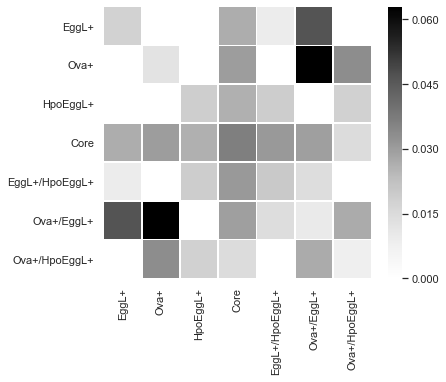

In [44]:
fig = plt.figure(figsize=(6,5))
sns.heatmap(df, cmap="Greys", linewidths=.75)
fig.savefig(os.path.join(resultpath,"Figures/Meta_Network_EdgeDensity_Heatmap.svg"))

# Analyzing centrality differences between core and other modules

In [16]:
betweenness = pd.read_csv(os.path.join(data, "ScreenPPI_Betweenness.csv"))
closeness = pd.read_csv(os.path.join(data, "ScreenPPI_Closeness.csv"))
eigenvector = pd.read_csv(os.path.join(data, "ScreenPPI_Eigenvector.csv"))
degrees_cen = pd.read_csv(os.path.join(data, "ScreenPPI_DegreeCentrality.csv"))

In [17]:
metrics = betweenness.merge(closeness, on='FbID').merge(eigenvector, on='FbID').merge(degrees_cen, on="FbID")
metrics

,FbID,Betweeness,Closeness,EigenVector,DegreeC
0,FBgn0001199,0.000507,0.326043,0.001665,0.005550
1,FBgn0010434,0.000440,0.332215,0.005553,0.003763
2,FBgn0027594,0.000023,0.275844,0.000217,0.000753
3,FBgn0000283,0.000676,0.339115,0.005222,0.006302
4,FBgn0002781,0.002812,0.350032,0.002764,0.007149
...,...,...,...,...,...
10627,FBgn0036492,0.000000,0.285839,0.000573,0.000094
10628,FBgn0038295,0.000000,0.285839,0.000573,0.000094
10629,FBgn0011589,0.000000,0.285839,0.000573,0.000094
10630,FBgn0037915,0.000000,0.280450,0.000428,0.000094


In [18]:
modules = [ova_module, fec_module, xRNAi_module]
modules_label = ['Ova', 'HpoEggL', 'EggL']

result = metrics[metrics['FbID'].isin(core_module)]
result['Module'] = "Core"

for i in range(3):
    module = modules[i]
    module_label = modules_label[i]
    testing_module = [n for n in module if n not in core_module]
    testing_metric = metrics[metrics['FbID'].isin(testing_module)]
    testing_metric['Module'] = module_label
    result = result.append(testing_metric)

/Users/xqua/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/xqua/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [19]:
result = result.melt(['FbID', 'Module'])

In [20]:
result['variable'].unique()

array(['Betweeness', 'Closeness', 'EigenVector', 'DegreeC'], dtype=object)

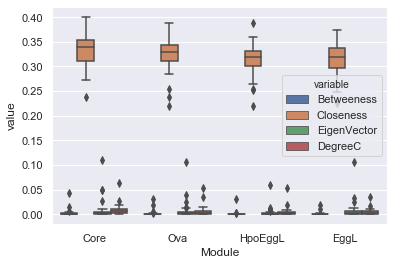

In [21]:
sns.boxplot(data=result, x='Module', y='value', hue='variable')

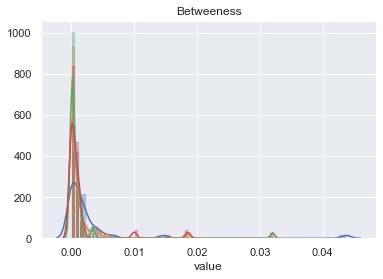

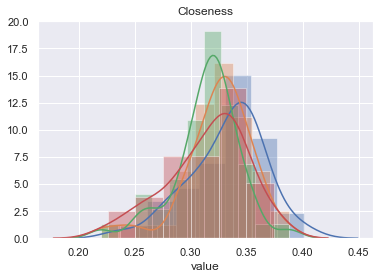

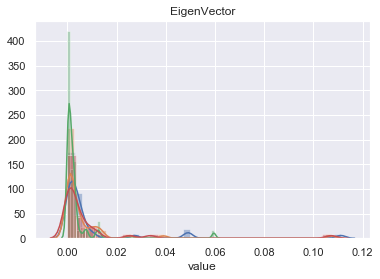

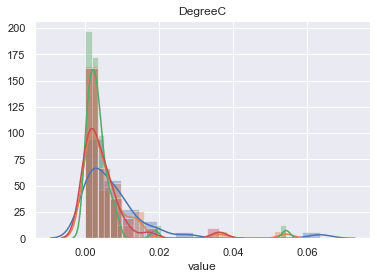

In [22]:
for metric in ['Betweeness', 'Closeness', 'EigenVector', 'DegreeC']:
    plt.figure()
    plt.title(metric)
    for module in result['Module'].unique():
        sns.distplot(a=result[(result['variable'] == metric) & (result['Module'] == module)]['value'])
   

Umann Betweeness Core HpoEggL 0.008656867817380235
Umann Betweeness Core EggL 0.014928019080819026
Umann Betweeness HpoEggL Core 0.008656867817380235
Umann Betweeness EggL Core 0.014928019080819026
Umann Closeness Core HpoEggL 0.0024445116031373516
Umann Closeness Core EggL 0.018963005838982146
Umann Closeness Ova HpoEggL 0.023524338527204838
Umann Closeness HpoEggL Core 0.0024445116031373516
Umann Closeness HpoEggL Ova 0.023524338527204838
Umann Closeness EggL Core 0.018963005838982146
Umann EigenVector Core HpoEggL 0.01444711655319972
Umann EigenVector Ova HpoEggL 0.0357204862077982
Umann EigenVector HpoEggL Core 0.01444711655319972
Umann EigenVector HpoEggL Ova 0.0357204862077982
Umann DegreeC Core HpoEggL 0.013031183904074381
Umann DegreeC Core EggL 0.030219608417371664
Umann DegreeC HpoEggL Core 0.013031183904074381
Umann DegreeC EggL Core 0.030219608417371664


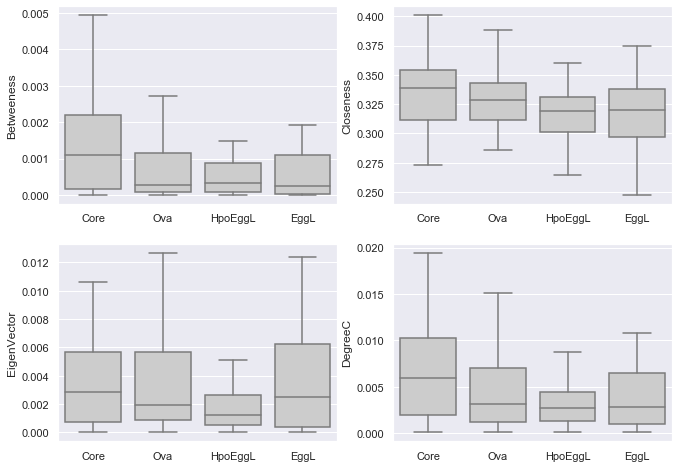

In [23]:
fig = plt.figure(figsize=(11,8))
c = 1
colors = ["#cc8888", "#cccccc", "#cccccc", "#cccccc"]
for metric in ['Betweeness', 'Closeness', 'EigenVector', 'DegreeC']:
    ax = fig.add_subplot(2,2,c)
    sns.boxplot(data=result[result['variable'] == metric], x='Module', y='value', color="#cccccc", showfliers=False)
    plt.xlabel("")
    plt.ylabel(metric)
    for module1 in result['Module'].unique():
        X = result[(result['variable'] == metric) & (result['Module'] == module1)]['value'].values
        for module2 in result['Module'].unique():
            Y = result[(result['variable'] == metric) & (result['Module'] == module2)]['value'].values
            s,p = stats.mannwhitneyu(X, Y)
            if p < 0.05:
                print("Umann",metric, module1, module2, p)
    c += 1
fig.savefig(os.path.join(resultpath, "CoreVSModules_Centrality.svg"))

# Making a heatmap of signaling pathway per group

In [51]:
sigs = signaling.groupby('Sig', as_index=False).count().sort_values('FbID')['Sig'].values

In [52]:
data = metatable.groupby(['Overlap'], as_index=False).mean()[['Overlap'] + list(sigs)]

In [53]:
index_order = metatable.groupby('Overlap', as_index=False).count().sort_values('FbID')['Overlap'].values

In [54]:
sorterIndex = dict(zip(index_order,range(len(index_order))))

In [55]:
data['Rank'] = data['Overlap'].map(sorterIndex)
data.index = data['Overlap']

In [56]:
data.sort_values(['Rank'], \
        ascending = [True], inplace = True)

In [57]:
del(data['Overlap'])
del(data['Rank'])

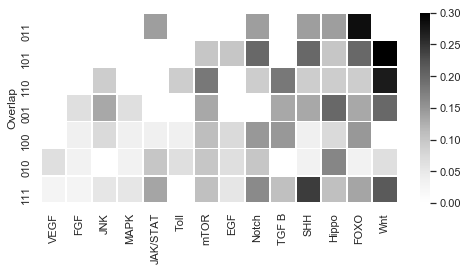

In [58]:
fig = plt.figure(figsize=(8,3.5))
sns.heatmap(data, cmap="Greys", linewidths=.75)
fig.savefig(os.path.join(resultpath,"Figures/Meta_Network_Signaling_Heatmap.svg"))